## Kaggle Competition | Titanic Machine Learning from Disaster 

### Notebook Overview

This notebook contains the final model used for the predictions of my final submission for the Titanic machine learning competition on Kaggle.com. More information on this competition can be found [here](https://www.kaggle.com/c/titanic). The objective of this competition is to successfully predict whether or not a passenger survived on the Titanic.

In [1]:
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_curve, f1_score, confusion_matrix, classification_report
%matplotlib inline

After running this notebook, I decided to hide all `UserWarning` messages since there were quite a few while munging and several columns in the dataset. I do this below. I also use seaborn's `whitegrid` styling for the visuals in this notebook.

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
sns.set_style('whitegrid')

Below I load in the data using Pandas.

In [3]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

The training dataset has 891 rows and 12 columns, while the test dataset has 418 rows and 11 columns. 

In [4]:
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


Several of the features I want to either update or engineer require the use of dummy variables. To make sure each dataset has each of these variables, I combine them together for the time being.

In [5]:
combined_df = pd.concat([train_df, test_df], ignore_index=True)

Below is a snapshot of the combined dataset.

In [6]:
combined_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


I decided to fill both the `Age` and `Fare` null values with the median value for each feature.

In [7]:
combined_df.loc[combined_df.Age.isnull(), 'Age'] = combined_df.Age.median()
combined_df.loc[combined_df.Fare.isnull(), 'Age'] = combined_df.Fare.median()

Next I use scikit-learn's `LabelEncoder` class to encode multiple existing categorical features in the dataset.

In [8]:
combined_df['Embarked'] = LabelEncoder().fit_transform(combined_df.Embarked.apply(lambda x: x if not pd.isnull(x) else 'S'))
combined_df['Sex'] = LabelEncoder().fit_transform(combined_df.Sex)
combined_df['Pclass'] = LabelEncoder().fit_transform(combined_df.Pclass)

Below is the result of encoding these features.

In [9]:
combined_df[['Embarked', 'Sex', 'Pclass']].head()

,Embarked,Sex,Pclass
0,2,1,2
1,0,0,0
2,2,0,2
3,2,0,0
4,2,1,2


Next, I tackle the `Name` attribute. Most passengers include some type of surname, so I extract those to include in the model.

In [10]:
combined_df['Surname'] = combined_df.Name.str.extract('([A-Za-z]+\.)', expand=False)

Based on my exploratory data analysis, I found several surnames that are duplicates. Thus, I combined any duplicates to avoid misleading my final model.

In [11]:
combined_df['Surname'] = combined_df.Surname.str.replace('Mlle', 'Miss')
combined_df['Surname'] = combined_df.Surname.str.replace('Ms', 'Miss')
combined_df['Surname'] = combined_df.Surname.str.replace('Mme', 'Mrs')

After updating the duplicates, I label all other types of surnames as `Rare`, since they are not as common as the major surnames including the 3 above.

In [12]:
for s in ['Lady', 'Countess', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Sir.', 'Jonkheer.', 'Dona.', 'Rev.']:
    combined_df['Surname'] = combined_df.Surname.str.replace(s, 'Rare')

Finally in regards to my new `Surname` feature, I label encode it using the `LabelEncoder` class.

In [13]:
combined_df['Surname'] = LabelEncoder().fit_transform(combined_df.Surname)

Next I create a couple of additional features using `Age`, `Sibsp`, and `Parch`. First, I cut the `Age` feature into 5 categories, and label encode it. 

In [14]:
combined_df['AgeTier'] = LabelEncoder().fit_transform(pd.cut(combined_df.Age, 5))

I do something similar with my new feature `FamilySize`, which adds both `Sibsp` and `Parch` together.

In [15]:
combined_df['FamilySize'] = LabelEncoder().fit_transform(pd.cut(combined_df.SibSp + combined_df.Parch, 5))

Next, I extract any letters from the `Ticket` feature to see if this helps the model learn at all. Any values that return null are replaced with `Other`.

In [16]:
combined_df['LetterTickets'] = combined_df.Ticket.astype(str).str.extract('([A-Za-z]+)', expand=False)
combined_df.loc[combined_df.LetterTickets.isnull(), 'LetterTickets'] = 'Other'

In regards to the `Cabin` feature, I assign labels to each row if the cabin starts with a particular letter. Any null values are filled with a 0.

In [17]:
combined_df.Cabin.fillna('0', inplace=True)
combined_df.loc[combined_df.Cabin.str[0] == 'A', 'Cabin'] = 1
combined_df.loc[combined_df.Cabin.str[0] == 'B', 'Cabin'] = 2
combined_df.loc[combined_df.Cabin.str[0] == 'C', 'Cabin'] = 3
combined_df.loc[combined_df.Cabin.str[0] == 'D', 'Cabin'] = 4
combined_df.loc[combined_df.Cabin.str[0] == 'E', 'Cabin'] = 5
combined_df.loc[combined_df.Cabin.str[0] == 'F', 'Cabin'] = 6
combined_df.loc[combined_df.Cabin.str[0] == 'G', 'Cabin'] = 7
combined_df.loc[combined_df.Cabin.str[0] == 'T', 'Cabin'] = 8

Finally, I create dummy variables for any categorical variables in the dataset, and drop any features I don't plan on using in my model.

In [18]:
combined_df = pd.get_dummies(combined_df, columns=['Embarked', 'Sex', 'Pclass', 'Surname', 'FamilySize', 'AgeTier', 
                                                  'Cabin', 'LetterTickets'])
combined_df.drop(['Ticket', 'SibSp', 'Parch', 'Name'], axis=1, inplace=True)

After munging, cleaning, and engineering new features, I need to slice my dataframe into train and test sets again for modeling.

In [19]:
train_df = combined_df[:891].drop('PassengerId', axis=1)
test_df = combined_df[891:]

Below, I create my labels and my features and split them up into training and testing sets. `X` is my matrix of features, so we need to remove the `Survived` column since that is what we are trying to predict.

In [20]:
y = train_df.Survived
X = train_df.ix[:, list(filter(lambda x: x != 'Survived', train_df.columns))]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Just for reference, the `X_train` feature matrix has 56 features at this point.

In [22]:
X_train.shape

(712, 56)

Below, I define a function that takes an sklearn `Pipeline` with parameters, and feeds it into grid search cross validation. This process helps hypertune my models parameters to find the best performing model. I chose f1 score as my scoring criteria because the classes in this classification task are highly skewed. Finally, I use `StratifiedKFold` as my splitting strategy, which will split the dataset into 10 folds, reflective of the data's class distributions.

Below are specifics on the difference features of the pipeline. 
* Dimensionality Reduction: `SelectKBest`
* Classifier: `RandomForestClassifier`

The only parameters I hypertuned were the number of features to use via `SelectKBest` and the number of estimators the `RandomForest` should use.

In [23]:
def make_grid_search(feats, dim_reducer, clf):
    pipe = Pipeline([('dim', dim_reducer), ('clf', clf)])
    param_grid = {'dim__k': list(range(1, feats.shape[1], 2)), 
                 'clf__n_estimators': list(range(200, 600, 100))}
    return GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, scoring='f1', cv=StratifiedKFold(10))

In [24]:
gscv = make_grid_search(X, SelectKBest(), RandomForestClassifier(random_state=42))
gscv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       error_score='raise',
       estimator=Pipeline(steps=[('dim', SelectKBest(k=10, score_func=<function f_classif at 0x113bae378>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'dim__k': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55], 'clf__n_estimators': [200, 300, 400, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

Below is the best estimator returned from grid search cross validation. 19 features were selected via `SelectKBest` and 300 estimators were used via the Random Forest.

In [25]:
gscv.best_estimator_

Pipeline(steps=[('dim', SelectKBest(k=19, score_func=<function f_classif at 0x113bae378>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False))])

This model has an F1 score of approximately 81% and an accuracy score of 83%

In [26]:
cv_preds = gscv.predict(X_test)
print('F1 Score: ', f1_score(y_test, cv_preds))
print('Accuracy Score: ', accuracy_score(y_test, cv_preds))

F1 Score:  0.807947019868
Accuracy Score:  0.837988826816


The learning curve below shows a relatively stable model, with more features causing the cross-validation error to decrease.

<module 'matplotlib.pyplot' from '/Users/blake/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py'>

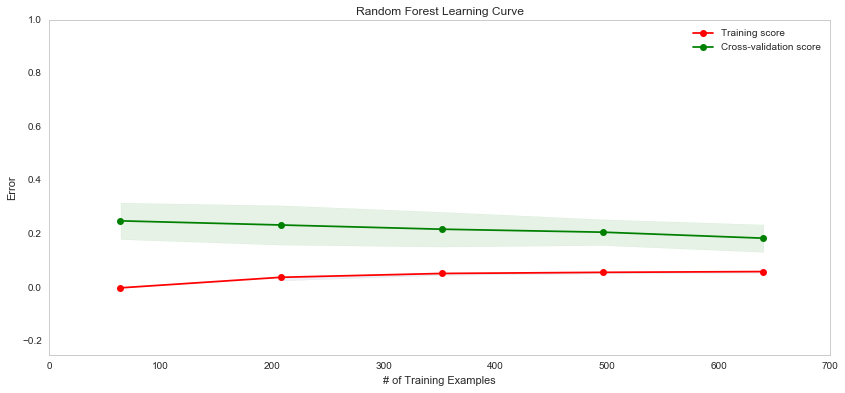

In [27]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(14, 6))
    plt.title(title)
    plt.ylim(-.25, 1, .1)
    plt.xlabel('# of Training Examples')
    plt.ylabel('Error')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=StratifiedKFold(10), 
                                                           n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, 1 - train_scores_mean - train_scores_std, 
                    1 - train_scores_mean, train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, 1 - test_scores_mean - test_scores_std, 
                    1 - test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, 1 - train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, 1 - test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    return plt
plot_learning_curve(gscv.best_estimator_, 'Random Forest Learning Curve', X_train, y_train)

Below is the confusion matrix for the cross validation predictions and the test predictions.

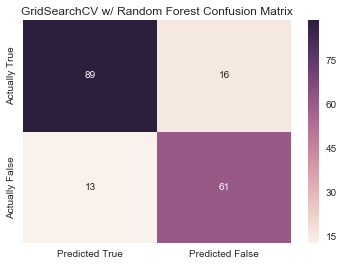

In [28]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test, cv_preds), columns=['Predicted True', 'Predicted False'],
            index=['Actually True', 'Actually False']), annot=True)
plt.title('GridSearchCV w/ Random Forest Confusion Matrix')

More specifically, precision is much higher for death predictions than survival predictions. However recall is less variated between the two classes.

In [29]:
print(classification_report(y_test, cv_preds))

             precision    recall  f1-score   support

        0.0       0.87      0.85      0.86       105
        1.0       0.79      0.82      0.81        74

avg / total       0.84      0.84      0.84       179



Below I defined a function to create a ROC curve, as another visualization to see how well the model is performing. As the area under the curve gets larger, the better the model is performing.

In [30]:
def make_roc_curve(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    return pd.DataFrame.from_items(roc_items)

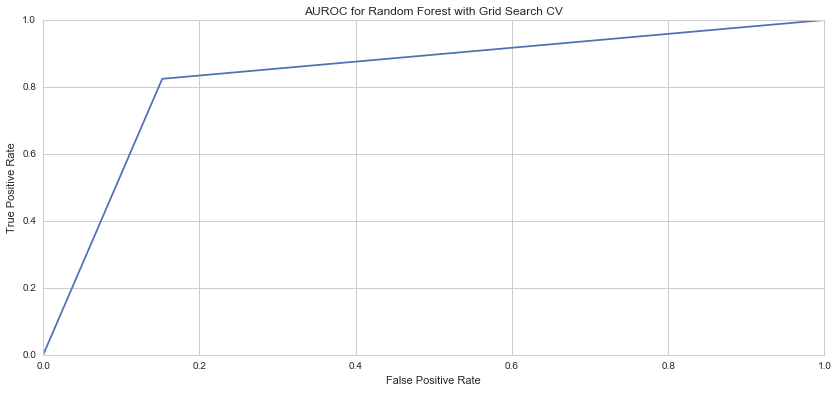

In [31]:
make_roc_curve(y_test, cv_preds).plot(x='fpr', y='tpr', 
                                      figsize=(14, 6), 
                                      title='AUROC for Random Forest with Grid Search CV')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend('')